# WORK IN PROGRESS

# Airline Loyal Program Analysis

#### The purpose of this analysis is to address the following questions:

#### 1. What impact did the campaign have on program memberships (gross / net)?

#### 2. Was the campaign adoption more successful for certain demographics of loyalty members?

#### 3. What impact did the campaign have on booked flights during summer?

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Exploratory Analysis / Data Cleaning
The structure of the datasets was observed to determine how to prepare the datasets to address the business tasks. The dataset was primarily focused on Customer Lifetime Value (CLV), which was calculated by the total invoice value for all the flights the member booked, and the Enrollment Type, where customers were either enrolled in the standard or the 2018 promotion program.

To clean the dataset for calculations and visualizations, the analysis conducted the following steps:
* Merged the flight activity and loyalty history datasets by Loyalty Number.
* Renamed variables for consistency.
* Concatenated month and year into a string to form the Enrollment Date and Cancellation Date columns.
* Imputed NA and NaT for missing values in Cancellation Date so that people who are still enrolled are accounted for.

In [2]:
loyalty = pd.read_csv("/kaggle/input/airline-loyalty-program/Customer Loyalty History.csv")
flights = pd.read_csv("/kaggle/input/airline-loyalty-program/Customer Flight Activity.csv")

print(f'Loyalty: {loyalty.info()}')
print(f'Flights: {flights.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [3]:
members = loyalty.drop_duplicates(subset = 'Loyalty Number').copy()

# Create Enrollmeent Period Date
members['EnrollPeriod'] = pd.to_datetime({
    'year': members['Enrollment Year'].astype(int),
    'month': members['Enrollment Month'].astype(int),
    'day': 1
})

# Create Cancel Period Date
members['CancelPeriod'] = pd.to_datetime({
    'year': members['Cancellation Year'].fillna(0).astype(int),
    'month': members['Cancellation Month'].fillna(1).astype(int),
    'day': 1
}, errors='coerce')

print(f'Members: {members.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Loyalty Number      16737 non-null  int64         
 1   Country             16737 non-null  object        
 2   Province            16737 non-null  object        
 3   City                16737 non-null  object        
 4   Postal Code         16737 non-null  object        
 5   Gender              16737 non-null  object        
 6   Education           16737 non-null  object        
 7   Salary              12499 non-null  float64       
 8   Marital Status      16737 non-null  object        
 9   Loyalty Card        16737 non-null  object        
 10  CLV                 16737 non-null  float64       
 11  Enrollment Type     16737 non-null  object        
 12  Enrollment Year     16737 non-null  int64         
 13  Enrollment Month    16737 non-null  int64     

#### NOTE: The promotional campaign only lasted for two months between February and April 2018 while the dataset ranges from April 2012 to December 2018.

In [4]:
# Filter for 2018
en18 = members[members['Enrollment Year'] == 2018]

# Campaign start and end date
campaign_start_end_dates = en18.groupby('Enrollment Type')['EnrollPeriod'].agg(['min', 'max'])

historical_start_end_dates = members.groupby('Enrollment Type')['EnrollPeriod'].agg(['min', 'max'])

# campaign_start_end_dates
print(f'Campaign Period: {campaign_start_end_dates}')
print(f'Dataset Range: {historical_start_end_dates}')

Campaign Period:                        min        max
Enrollment Type                      
2018 Promotion  2018-02-01 2018-04-01
Standard        2018-01-01 2018-12-01
Dataset Range:                        min        max
Enrollment Type                      
2018 Promotion  2018-02-01 2018-04-01
Standard        2012-04-01 2018-12-01


In [5]:
# Filter for Feb-Apr enrollments in 2016, 2017, and 2018
selected_years = [2016, 2017, 2018]
enrollments_feb_apr = loyalty[
    (loyalty["Enrollment Year"].isin(selected_years)) &
    (loyalty["Enrollment Month"].between(2, 4))
]

# Group to get Gross and Net figures
gross_enrollments = enrollments_feb_apr.groupby("Enrollment Year")["Loyalty Number"].nunique().rename("Gross")
cancellations = enrollments_feb_apr[
    loyalty["Cancellation Year"] == loyalty["Enrollment Year"]
].groupby("Enrollment Year")["Loyalty Number"].nunique().rename("Canceled")

net_enrollments = pd.concat([gross_enrollments, cancellations], axis=1).fillna(0).astype(int)
net_enrollments["Net"] = net_enrollments["Gross"] - net_enrollments["Canceled"]


/tmp/ipykernel_13/1900784827.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cancellations = enrollments_feb_apr[


In [6]:
members = members.rename(columns={
    'Enrollment Type': 'EnrollmentType',
    'Marital Status':  'MaritalStatus',
    'Loyalty Card':  'LoyaltyCard',
})

model = smf.ols(
    'CLV ~ C(EnrollmentType) + C(Gender) + C(LoyaltyCard) + C(MaritalStatus)',
    data = members.dropna(subset=['Salary'])
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CLV   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     92.80
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          1.85e-114
Time:                        16:43:25   Log-Likelihood:            -1.2804e+05
No. Observations:               12499   AIC:                         2.561e+05
Df Residuals:                   12492   BIC:                         2.561e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

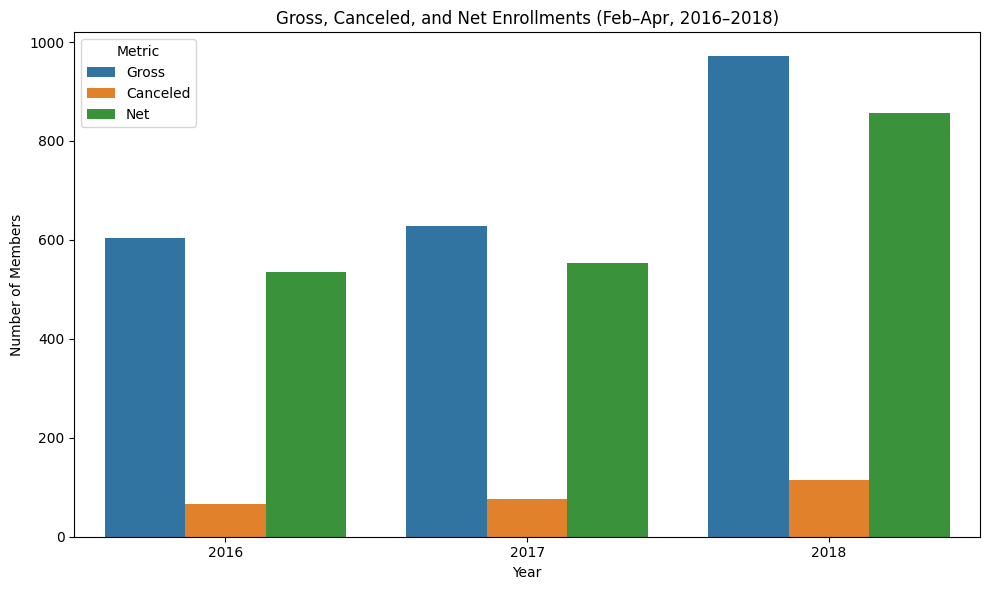

In [7]:
net_enrollments_plot = net_enrollments.reset_index().melt(id_vars="Enrollment Year", var_name="Metric", value_name="Count")

# Create grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=net_enrollments_plot, x="Enrollment Year", y="Count", hue="Metric")
plt.title("Gross, Canceled, and Net Enrollments (Feb–Apr, 2016–2018)")
plt.ylabel("Number of Members")
plt.xlabel("Year")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [8]:
# Create Gross, Cancel, and Net Table
impact18 = pd.concat([
    en18.groupby('Enrollment Type')['Loyalty Number'].nunique().rename('Gross'),
    en18[en18['Cancellation Year'] == 2018].groupby('Enrollment Type')['Loyalty Number'].nunique().rename('Canceled')
    ], axis = 1).fillna(0).astype(int)


impact18['Net'] = impact18['Gross'] - impact18['Canceled']
impact18

,Gross,Canceled,Net
Enrollment Type,,,
2018 Promotion,971,115,856
Standard,2039,44,1995


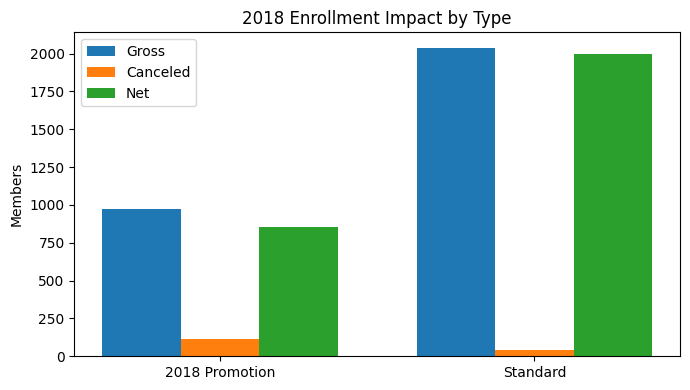

In [9]:
# Barchart of 2018 Enrollment by Type
labels = impact18.index
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width, impact18['Gross'],   width, label='Gross')
ax.bar(x, impact18['Canceled'],width, label='Canceled')
ax.bar(x + width, impact18['Net'],     width, label='Net')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Members')
ax.set_title('2018 Enrollment Impact by Type')
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Compare CLV mean and count by demographic
def clv_pivot(df, col):
    s = df.groupby([col,'EnrollmentType']).agg(
        MeanCLV=('CLV','mean'),
        Count=('Loyalty Number','nunique')
    ).unstack(fill_value=0)
    s.columns = [f'{agg}_{etype}' for agg,etype in s.columns]
    return s

demo_cols = ['Gender','Education','MaritalStatus','LoyaltyCard']
pivots = {c: clv_pivot(members, c) for c in demo_cols}
pivots['Gender']

,MeanCLV_2018 Promotion,MeanCLV_Standard,Count_2018 Promotion,Count_Standard
Gender,,,,
Female,8047.229130,7978.432981,494,7916
Male,8045.766499,7992.321532,477,7850


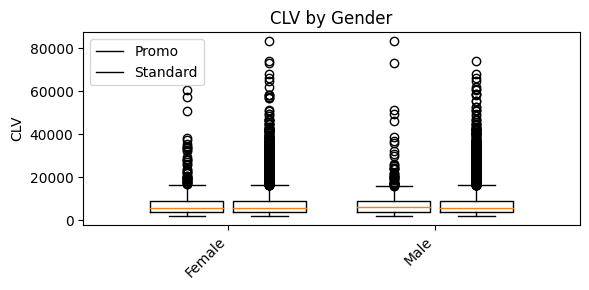

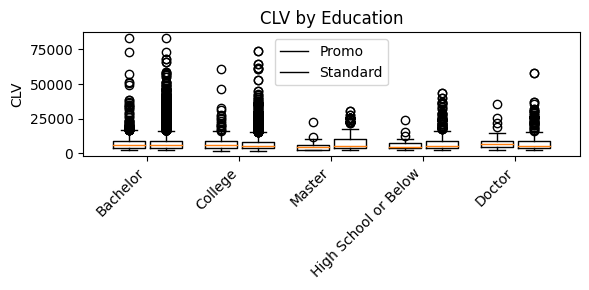

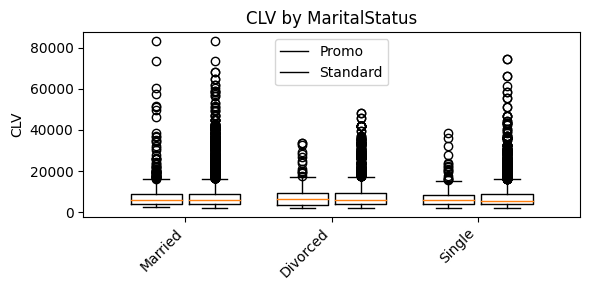

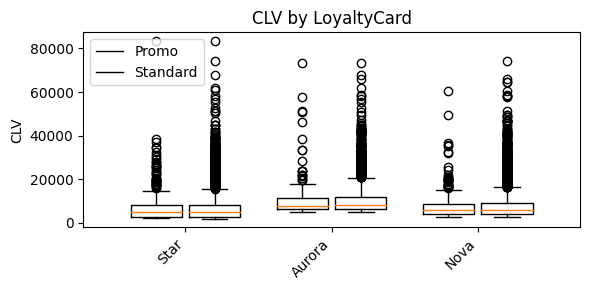

In [11]:
for demo in demo_cols:
    cats = members[demo].unique()
    promo = [members[(members[demo] == cat) & (members['EnrollmentType'] == '2018 Promotion')]['CLV'] for cat in cats]
    standard = [members[(members[demo] == cat) & (members['EnrollmentType'] == 'Standard')]['CLV'] for cat in cats]
    fig, ax = plt.subplots(figsize = (6,3))
    ax.boxplot(promo, positions = np.arange(len(cats)), widths = 0.35)
    ax.boxplot(standard, positions = np.arange(len(cats)) + 0.4, widths = 0.35)
    ax.set_xticks(np.arange(len(cats)) + 0.2)
    ax.set_xticklabels(cats, rotation = 45, ha = 'right')
    ax.set_ylabel('CLV')
    ax.set_title(f'CLV by {demo}')
    ax.legend(['Promo','Standard'])
    plt.tight_layout()
    plt.show()

In [12]:
act = flights.merge(
    members[['Loyalty Number','EnrollmentType','EnrollPeriod']],
    on='Loyalty Number',
    how='left'
)

# build a “first-of-month” date for each flight
act['FlightPeriod'] = pd.to_datetime({
    'year':  act['Year'].astype(int),
    'month': act['Month'].astype(int),
    'day':   1
})

# filter Jun–Aug 2018 AND flights on/after enrollment
mask = (
    act['FlightPeriod'].dt.to_period('M').isin(pd.period_range('2018-06','2018-08',freq='M'))
    & (act['FlightPeriod'] >= act['EnrollPeriod'])
)
summer_act = act.loc[mask].copy()

# Summer Enrollment Totals
member_summer = (
    summer_act
    .groupby(['EnrollmentType','Loyalty Number'])
    .agg(
        TotalFlights  = ('Total Flights','sum'),
        TotalDistance = ('Distance','sum'),
        PointsAccumulated = ('Points Accumulated', 'sum'),
        PointsRedeemed = ('Points Accumulated', 'sum'),
        DollarCostPointsRedeemed =('Dollar Cost Points Redeemed','sum')
    )
    .reset_index()
)

# Roll up to cohort
impact_summer = (
    member_summer
    .groupby('EnrollmentType')
    .agg(
        AvgFlightsPerMember  = ('TotalFlights','mean'),
        TotalFlightsSum      = ('TotalFlights','sum'),
        PointsAccumalted = ('PointsAccumulated', 'sum'),
        PointsRedeemed = ('PointsAccumulated', 'sum'),
        DollarCostPointsRedeemed =('DollarCostPointsRedeemed','sum'),
        MemberCount          = ('Loyalty Number','nunique'),
        AvgDistancePerMember = ('TotalDistance','mean'),
        TotalDistanceSum     = ('TotalDistance','sum')
    )
    .round(2)
)

impact_summer

,AvgFlightsPerMember,TotalFlightsSum,PointsAccumalted,PointsRedeemed,DollarCostPointsRedeemed,MemberCount,AvgDistancePerMember,TotalDistanceSum
EnrollmentType,,,,,,,,
2018 Promotion,24.76,24040,53968062.0,53968062.0,23202,971,37053.25,35978708
Standard,5.36,79775,119844531.0,119844531.0,337096,14884,8051.90,119844531


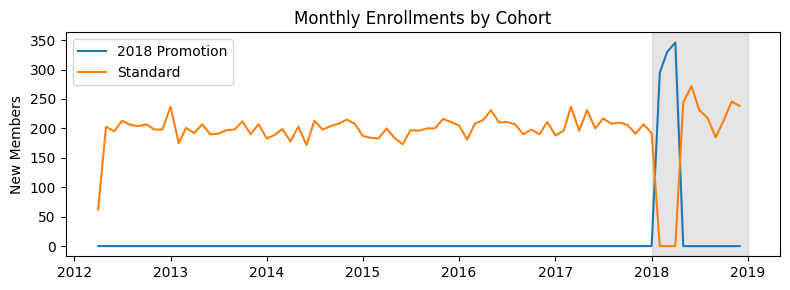

In [13]:
m = members.copy()
m['YM'] = m['EnrollPeriod'].dt.to_period('M').dt.to_timestamp()
monthly = m.groupby(['YM','EnrollmentType'])['Loyalty Number'].nunique().unstack().fillna(0).sort_index()

fig, ax = plt.subplots(figsize=(8,3))
for col in monthly.columns:
    ax.plot(monthly.index, monthly[col], label=col)
ax.axvspan('2018-01-01','2018-12-31', color='grey', alpha=0.2)
ax.set_title('Monthly Enrollments by Cohort')
ax.set_ylabel('New Members')
ax.legend()
plt.tight_layout()
plt.show()

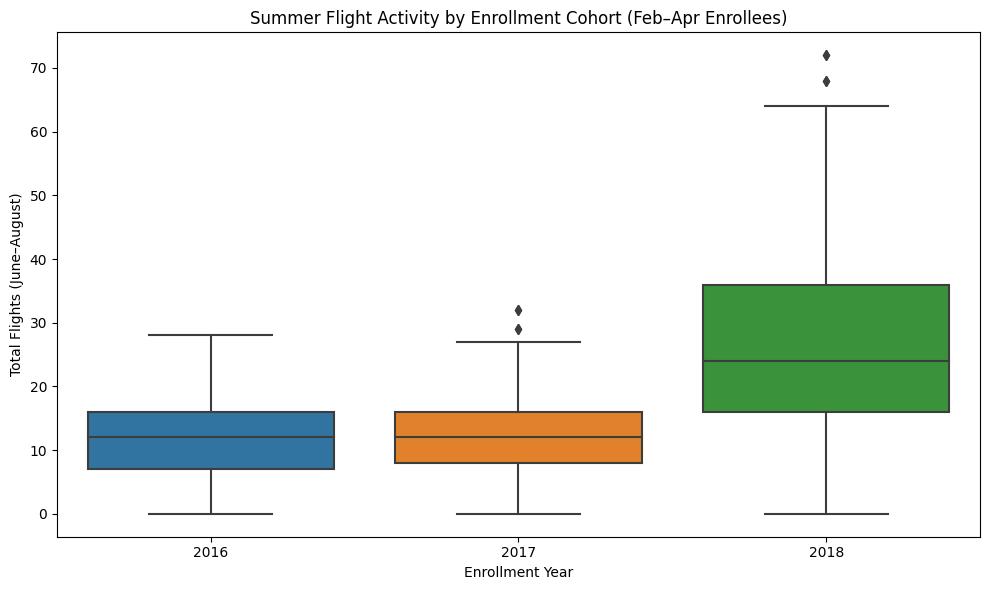

In [14]:
cohorts = loyalty[
    loyalty["Enrollment Year"].isin([2016, 2017, 2018]) &
    loyalty["Enrollment Month"].between(2, 4)
][["Loyalty Number", "Enrollment Year"]].rename(columns={"Enrollment Year": "CohortYear"})

# Prepare summer flight activity (June–August)
summer_flights = flights[flights["Month"].isin([6, 7, 8])]

# Aggregate total flights per member
summer_agg = summer_flights.groupby("Loyalty Number")["Total Flights"].sum().reset_index()
summer_agg = summer_agg.merge(cohorts, on="Loyalty Number", how="inner")

# Visualize with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=summer_agg, x="CohortYear", y="Total Flights")
plt.title("Summer Flight Activity by Enrollment Cohort (Feb–Apr Enrollees)")
plt.ylabel("Total Flights (June–August)")
plt.xlabel("Enrollment Year")
plt.tight_layout()
plt.show()

In [15]:
members = members.rename(columns={
    'Enrollment Type': 'EnrollmentType',
    'Marital Status':  'MaritalStatus',
    'Loyalty Card':  'LoyaltyCard',
})

model = smf.ols(
    'CLV ~ C(EnrollmentType) + C(Gender) + C(Education) + C(MaritalStatus) + C(City) + C(LoyaltyCard)',
    data = members.dropna(subset=['Salary'])
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CLV   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     16.09
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           3.12e-99
Time:                        16:43:28   Log-Likelihood:            -1.2802e+05
No. Observations:               12499   AIC:                         2.561e+05
Df Residuals:                   12461   BIC:                         2.564e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [16]:
# Prepare samples
flights_2016 = summer_agg[summer_agg["CohortYear"] == 2016]["Total Flights"]
flights_2017 = summer_agg[summer_agg["CohortYear"] == 2017]["Total Flights"]
flights_2018 = summer_agg[summer_agg["CohortYear"] == 2018]["Total Flights"]

# Perform t-tests
t_16_vs_18 = ttest_ind(flights_2016, flights_2018, equal_var=False)
t_17_vs_18 = ttest_ind(flights_2017, flights_2018, equal_var=False)

# Format results
{
    "T-test: 2016 vs 2018 (p-value)": t_16_vs_18.pvalue,
    "T-test: 2017 vs 2018 (p-value)": t_17_vs_18.pvalue,
    "Mean Flights 2016": flights_2016.mean(),
    "Mean Flights 2017": flights_2017.mean(),
    "Mean Flights 2018": flights_2018.mean()
}

{'T-test: 2016 vs 2018 (p-value)': 3.4840644438096215e-107,
 'T-test: 2017 vs 2018 (p-value)': 1.4947402000493487e-101,
 'Mean Flights 2016': 11.192371475953566,
 'Mean Flights 2017': 11.87758346581876,
 'Mean Flights 2018': 24.757981462409887}

In [17]:
# Create campaign flag
loyalty["EnrollDate"] = pd.to_datetime({
    "year": loyalty["Enrollment Year"],
    "month": loyalty["Enrollment Month"],
    "day": 1
})
loyalty["CampaignMember"] = loyalty["EnrollDate"].between("2018-02-01", "2018-04-30")

# Filter for campaign members
campaign = loyalty[loyalty["CampaignMember"] == True].dropna(subset=["Province", "Loyalty Card"])

# Sort provinces by descending total campaign members
province_totals = campaign["Province"].value_counts().sort_values(ascending=False)
province_order = province_totals.index.tolist()

# Group and compute proportions
grouped = campaign.groupby(["Province", "Loyalty Card"]).size().unstack(fill_value=0).reindex(index=province_order)
province_widths = grouped.sum(axis=1) / grouped.sum().sum()
proportions = grouped.div(grouped.sum(axis=1), axis=0)
x_positions = province_widths.cumsum() - province_widths / 2

# Create figure
fig = go.Figure()
cumulative_base = pd.Series(0, index=province_order)

for card in grouped.columns:
    height = proportions[card]
    absolute = grouped[card]
    share_percent = (height * 100).round(1).astype(str) + '%'

    customdata = list(zip(height.index, [card]*len(height), absolute, share_percent))

    fig.add_trace(go.Bar(
        x=x_positions,
        y=height,
        width=province_widths,
        base=cumulative_base,
        name=card,
        customdata=customdata,
        hovertemplate="<b>%{customdata[0]}</b><br>Card: %{customdata[1]}<br>Members: %{customdata[2]}<br>Share of Province: %{customdata[3]}<extra></extra>"
    ))
    cumulative_base += height

# Add total labels above columns
for x, province in zip(x_positions, province_order):
    total = grouped.loc[province].sum()
    fig.add_annotation(
        x=x,
        y=1.05,
        text=f"<b>{total}</b>",
        showarrow=False,
        font=dict(size=11),
        yanchor="bottom"
    )

# Loyalty card totals to the right
card_totals = grouped.sum()
y_pos = 1.05
for card, total in card_totals.items():
    fig.add_annotation(
        x=1.01,
        y=y_pos,
        text=f"<b>{card}: {total}</b>",
        showarrow=False,
        xanchor="left",
        font=dict(size=11)
    )
    y_pos -= 0.08

# Adjust layout
fig.update_layout(
    barmode='stack',
    title={
        'text': 'Loyalty Card Distribution During Promotion by Province',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=province_order,
        title='Province',
        tickangle=60
    ),
    yaxis=dict(
        title='Proportion by Loyalty Card',
        tickformat=".0%",
        range=[0, 1.15]
    ),
    margin=dict(l=40, r=140, t=100, b=100),
    showlegend=True
)

fig.write_html("mekko_loyalty_province.html")
fig.show()

## 1. What impact did the campaign have compared to historical data (gross / net)?

Gross was defined as the number of new enrollments during the campaign period while net was the number of new enrollments minus the number of cancellations during the campaign period. The monthly net was calculated by taking the gross enrolllment and subtracting that total from the cancellations.


The analysis found that there was more gross enrollments and cancellations in the standard enrollments than the 2018 promotional enrollments.

There were proportionally fewer cancellations in the  2018 promotional group than the standard enrollment group.

The findings of the analysis suggest that those who were in the promotional group may be less likely to cancel their plan than those in the standard enrollment.

## 2. Was the campaign adoption more successful for certain demographics of loyalty members?

There was a high level of kurtosis in the dataset, suggesting that outliers may be skewing the results.




## 3. What impact did the campaign have on booked flights during summer?

During the 2018 promotion, those in the the promotional group tended to fly more and travelled farther than those in the standard enrollment type. There was also a significant increase in the mean number of flights in 2018 compared to 2016 and 2017.


# Conclusion and Recommendations

The findings of the analysis suggest that the 2018 promotional event did have a significant effect on the number of miles travelled and flights taken.

The analysis recommends that the airline finds incentives to convert Star and Nova loyalty card members to become Aurura loyalty members since the average customer lifetime value is approximately $3000 more for Aurora level members. The business could focus on areas that would have the biggest impact like


Some limitations of the datasets include null and negative values for salary so further clarification would be necessary to improve accuracy.